In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
def ScreenToWorld(uv, depth, cam_dict):
    # print(uv.shape, depth.shape)
    depth = depth.reshape(-1)
    w = cam_dict['w']
    h = cam_dict['h']
    Iinv = np.linalg.inv(cam_dict['I'])
    Einv = cam_dict['Einv']
    uv = np.divide(uv, np.array([w, h])) # Normalize : (width, height) -> (-1, 1)
    uv = (uv * 2.0) - np.ones(shape=uv.shape, dtype=np.float32) # Normalize : (width, height) -> (-1, 1)
    uv = (uv.T * depth).T   # Normalize : (-1, 1) -> (-depth, depth) : Camera space (x', y', d, 1)
    uv = np.stack((uv[:, 0], uv[:, 1], depth, np.ones(depth.shape[0], dtype=np.float32)), axis=1) # Stack the screen with depth and w ===> (x, y, depth, 1)
    xyz = ((Einv @ Iinv) @ uv.T).T # Reprojected

    return xyz[:, :3]

def WorldToScreen(world, cam_dict, normalize=False):
    world = np.concatenate((world, np.ones(shape=(world.shape[0], world.shape[1], 1))), axis=-1)
    I = cam_dict['I']
    E = cam_dict['E']
    w = cam_dict['w']
    h = cam_dict['h']
    transformation = (I @ E)
    ndc = (world @ transformation.T)
    if normalize:
            u = (ndc[..., [0]]/ndc[..., [2]] + 1) * .5
            v = (ndc[..., [1]]/ndc[..., [2]] + 1) * .5
    else:
            u = (((ndc[..., [0]]/ndc[..., [2]] + 1) * .5) * w)
            v = (((ndc[..., [1]]/ndc[..., [2]] + 1) * .5) * h)
    d = ndc[..., [2]]
    return u, v, d

In [17]:
f = "./mocap.npy"
u, v, intrinsic, extrinsic, extrinsic_inv, x, y, z = 0, 1, 2, 3, 4, 5, 6, 7
def load_f(f):
    dat = np.load(f, allow_pickle=True)
    return dat
dat = load_f(f)
E = dat[0][0][extrinsic]
I = dat[0][0][intrinsic]
print("Intrinsic : \n", I)
print("Extrinsic : \n", E)

Intrinsic : 
 [[ 1.5225779   0.          0.          0.        ]
 [ 0.          2.26409752  0.          0.        ]
 [ 0.          0.         -1.          0.        ]
 [ 0.          0.          0.          1.        ]]
Extrinsic : 
 [[-9.99919233e-01  1.21565028e-02  3.71529018e-03  2.20554426e-01]
 [ 6.92091896e-03  7.65799758e-01 -6.43041864e-01 -4.84756869e-01]
 [-1.06623079e-02 -6.42964253e-01 -7.65822107e-01  5.48669993e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [18]:

# Known ball size (in meters.) project to pixel
bz = 0.04   # Ball-size of pingpong
ball_size_in_world = np.array([[-bz/2, 0, 0],
                               [0, 0, 0],
                               [bz/2, 0, 0]])
bzw = np.expand_dims(ball_size_in_world, axis=0)                               

cam_dict = {'Einv':np.linalg.inv(E), 'I':I, 'E':E, 'w':1664, 'h':1088}
u, v, d = WorldToScreen(world=bzw, cam_dict=cam_dict)
uv = np.concatenate((u, v), axis=-1)
print("Ball in world : \n", bzw)
print("Ball in screen : \n", uv)

I_ = np.array([ 1.2486910446433503e+03, 0., 8.3830220156448183e+02, 0., 1.2501477559315435e+03, 5.7603222450306578e+02, 0., 0., 1. ]).reshape(3, 3)
pixel_size = 5.5e-6  # From Mocap camera datasheet
f = pixel_size * np.mean([I_[0][0], I_[1][1]])       # focal-length in world unit
diameter = np.abs(uv[0, 0, 0] - uv[0, 2, 0])
print("Diameter : ", diameter)
ball_size_pixel = np.pi * (diameter/2)**2
print("Ball size in pixel : ", ball_size_pixel)
depth = f * bz / ball_size_pixel   # Calandre et al.
print("Depth from Calandre et al. : ", depth)
xyz = ScreenToWorld(uv=np.array([[uv[0, 1, 0], uv[0, 1, 1]]]), depth=np.array([[depth]]), cam_dict=cam_dict)
print("XYZ : ", xyz)
# xyz = ScreenToWorld(uv=np.array([[uvd[0, 1, 0], uvd[0, 1, 1]]]), depth=np.array([[d[0, 1, 0]]]), cam_dict=cam_dict)
# print("XYZ : ", xyz)


Ball in world : 
 [[[-0.02  0.    0.  ]
  [ 0.    0.    0.  ]
  [ 0.02  0.    0.  ]]]
Ball in screen : 
 [[[776.46264453 652.84635864]
  [781.07776968 652.81951653]
  [785.69325359 652.79267234]]]
Diameter :  9.230609064293503
Ball size in pixel :  66.91917797411804
Depth from Calandre et al. :  4.107526069276421e-06
XYZ :  [[0.28239265 3.89629966 3.88929968]]


Intrinsic : 
 [[ 2.85686244  0.          0.          0.        ]
 [ 0.          5.07886655  0.          0.        ]
 [ 0.          0.         -1.          0.        ]
 [ 0.          0.          0.          1.        ]]
Extrinsic : 
 [[ 9.99988951e-01 -4.43629410e-03  1.55463296e-03  2.55612788e-02]
 [ 3.79039420e-03  9.56556150e-01  2.91523525e-01  1.35332548e+00]
 [ 2.78037781e-03  2.91514411e-01 -9.56562396e-01 -3.39227151e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


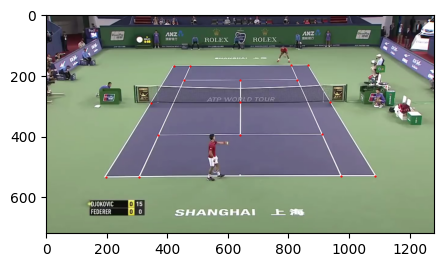

In [19]:
f = "./tennis.npy"
u, v, intrinsic, extrinsic, extrinsic_inv, x, y, z = 0, 1, 2, 3, 4, 5, 6, 7
def load_f(f):
    dat = np.load(f, allow_pickle=True)
    return dat

dat = load_f(f)
E = dat[0][0][extrinsic]
I = dat[0][0][intrinsic]
print("Intrinsic : \n", I)
print("Extrinsic : \n", E)

court_3d = np.array([[-5.4868, 0, -11.8872],
            [-5.4868, 0, 11.8872],
            [5.4868, 0, 11.8872], 
            [5.4868, 0, -11.8872], 
            [-4.1148, 0, -11.8872], 
            [-4.1148, 0, 11.8872], 
            [4.1148, 0, 11.8872],
            [4.1148, 0, -11.8872], 
            [-4.1148, 0, -6.4008],
            [4.1148, 0, -6.4008], 
            [-4.1148, 0, 6.4008],
            [4.1148, 0, 6.4008],
            [0, 0, -6.4008], 
            [0, 0, 6.4008],
            [-5.4868, 0, 0],
            [5.4868, 0, 0],
            [0, 0, 0]]).astype('float32')
court_3d = np.expand_dims(court_3d, axis=0)                               

cam_dict = {'Einv':np.linalg.inv(E), 'I':I, 'E':E, 'w':1280, 'h':720}
u, v, d = WorldToScreen(world=court_3d, cam_dict=cam_dict)
uv = np.concatenate((u, v), axis=-1)

from PIL import Image
img = './tennis_court.jpg'
pil_image = Image.open(img)
img = np.expand_dims(np.array(pil_image), axis=-1),

plt.figure(figsize=(5, 5), dpi=100)
plt.imshow(pil_image)

for i in range(uv.shape[1]):
    plt.scatter(uv[0, i, 0], 720-uv[0, i, 1], c='r', s=0.3)

plt.show()



In [23]:
bz = 0.064   # Ball-size of tennis in meter
ball_size_in_world = np.array([[-bz/2, 0, 0],
                               [bz/2, 0, 0]])
bzw = np.expand_dims(ball_size_in_world, axis=0)                               

cam_dict = {'Einv':np.linalg.inv(E), 'I':I, 'E':E, 'w':1280, 'h':720}
u, v, d = WorldToScreen(world=bzw, cam_dict=cam_dict)
uv = np.concatenate((u, v), axis=-1)
print("Ball in world : \n", bzw)
print("Ball in screen : \n", uv)
I_ = np.array([1828.391959798995, 0.0, 640.0, 0.0, 0.0, 1828.391959798995, 360.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]).reshape(4, 4)
pixel_size = 5.5e-6  # From Mocap camera datasheet
f = pixel_size * np.mean([I_[0][0], I_[1][1]])       # focal-length in world unit
diameter = np.abs(uv[0, 0, 0] - uv[0, 1, 0])
print("Diameter : ", diameter)
ball_size_pixel = np.pi * (diameter/2)**2
print("Ball size in pixel : ", ball_size_pixel)
depth = f * bz / ball_size_pixel   # Calandre et al.
print("Depth from Calandre et al. : ", depth)
xyz = ScreenToWorld(uv=np.array([[uv[0, 1, 0], uv[0, 1, 1]]]), depth=np.array([[depth]]), cam_dict=cam_dict)
print("XYZ : ", xyz)
print("Answer-XYZ : ", [0, 0, 0])

Ball in world : 
 [[[-0.032  0.     0.   ]
  [ 0.032  0.     0.   ]]]
Ball in screen : 
 [[[639.65298094 432.93582341]
  [643.10247009 432.94928108]]]
Diameter :  3.4494891490379587
Ball size in pixel :  9.345433417091705
Depth from Calandre et al. :  6.88672147267336e-05
XYZ :  [[  0.06362727   8.59452447 -32.84369292]]
Answer-XYZ :  [0, 0, 0]
